In [16]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# 1. Carga datos
train = pd.read_csv(
    "M:/DATA_ANALYTICS/Projects/Global_Air_Pollution_Prediction_Challenge/Data/train.csv"
)
test = pd.read_csv(
    "M:/DATA_ANALYTICS/Projects/Global_Air_Pollution_Prediction_Challenge/Data/test.csv"
)

# 2. Crear features
for df in [train, test]:
    df["weekday_x_month"] = df["day_of_week"] * df["month"]
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["doy_sin"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
    df["doy_cos"] = np.cos(2 * np.pi * df["day_of_year"] / 365)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    df["is_january"] = (df["month"] == 1).astype(int)
    df["hour_x_lat"] = df["hour"] * df["latitude"]

# 3. Clustering geográfico
cluster_features = ["latitude", "longitude"]
imputer = SimpleImputer(strategy="mean")

train[cluster_features] = imputer.fit_transform(train[cluster_features])
test[cluster_features] = imputer.transform(test[cluster_features])

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(train[cluster_features])

train["geo_cluster"] = kmeans.predict(train[cluster_features])
test["geo_cluster"] = kmeans.predict(test[cluster_features])

# 4. Features para modelado
features = [
    "hour",
    "month",
    "weekday_x_month",
    "hour_sin",
    "hour_cos",
    "doy_sin",
    "doy_cos",
    "month_sin",
    "month_cos",
    "is_january",
    "hour_x_lat",
    "latitude",
    "longitude",
]

train[features] = imputer.fit_transform(train[features])
test[features] = imputer.transform(test[features])

# 5. Log-transform target
epsilon = 1e-6
train["pollution_value_log"] = np.log(train["pollution_value"] + epsilon)

# 6. Entrenar modelos por cluster
cluster_models = {}
for cluster in sorted(train["geo_cluster"].unique()):
    print(f"Training cluster {cluster}...")
    cluster_data = train[train["geo_cluster"] == cluster]
    X_cluster = cluster_data[features]
    y_cluster = cluster_data["pollution_value_log"]

    rf = RandomForestRegressor(
        n_estimators=150,
        max_depth=25,
        min_samples_split=2,
        min_samples_leaf=2,
        random_state=42,
    )
    rf.fit(X_cluster, y_cluster)

    xgb = XGBRegressor(
        n_estimators=150,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0,
    )
    xgb.fit(X_cluster, y_cluster)

    cluster_models[cluster] = (rf, xgb)

# 7. Validar cluster por cluster (RMSE)
# Validar cluster por cluster con RMSE separado por modelo
rmses_rf = []
rmses_xgb = []

for cluster in sorted(train["geo_cluster"].unique()):
    cluster_data = train[train["geo_cluster"] == cluster]
    X_cluster = cluster_data[features]
    y_cluster = cluster_data["pollution_value_log"]

    rf_model, xgb_model = cluster_models[cluster]

    preds_rf = rf_model.predict(X_cluster)
    preds_xgb = xgb_model.predict(X_cluster)

    rmse_rf = np.sqrt(mean_squared_error(y_cluster, preds_rf))
    rmse_xgb = np.sqrt(mean_squared_error(y_cluster, preds_xgb))

    print(f"Cluster {cluster} RMSE RF: {rmse_rf:.4f}")
    print(f"Cluster {cluster} RMSE XGB: {rmse_xgb:.4f}")

    rmses_rf.append(rmse_rf)
    rmses_xgb.append(rmse_xgb)

print(f"Mean RF RMSE across clusters: {np.mean(rmses_rf):.4f}")
print(f"Mean XGB RMSE across clusters: {np.mean(rmses_xgb):.4f}")

# 8. Predecir test por cluster con blending
predictions = []

for idx, row in test.iterrows():
    cluster = int(row["geo_cluster"])  # <-- forzamos entero aquí
    rf_model, xgb_model = cluster_models[cluster]
    X_row = row[features].values.reshape(1, -1)

    # RMSE de cada modelo en este cluster
    rmse_rf = rmses_rf[cluster]
    rmse_xgb = rmses_xgb[cluster]

    # Calcular pesos inversos (más bajo RMSE, mayor peso)
    weight_rf = 1 / rmse_rf
    weight_xgb = 1 / rmse_xgb

    # Normalizar pesos
    total_weight = weight_rf + weight_xgb
    w_rf = weight_rf / total_weight
    w_xgb = weight_xgb / total_weight

    # Predicción ponderada
    pred_rf = rf_model.predict(X_row)[0]
    pred_xgb = xgb_model.predict(X_row)[0]

    pred_log = w_rf * pred_rf + w_xgb * pred_xgb
    pred = np.exp(pred_log) - epsilon
    pred = max(pred, 0)  # evitar negativos
    predictions.append(pred)

print("✅ Predicciones ponderadas por cluster listas.")

Training cluster 0...
Training cluster 1...
Training cluster 2...
Training cluster 3...
Training cluster 4...
Training cluster 5...
Training cluster 6...
Training cluster 7...
Training cluster 8...
Training cluster 9...
Cluster 0 RMSE RF: 0.2549
Cluster 0 RMSE XGB: 0.0784
Cluster 1 RMSE RF: 0.3483
Cluster 1 RMSE XGB: 0.1370
Cluster 2 RMSE RF: 0.2981
Cluster 2 RMSE XGB: 0.1409
Cluster 3 RMSE RF: 0.4580
Cluster 3 RMSE XGB: 0.0920
Cluster 4 RMSE RF: 0.1780
Cluster 4 RMSE XGB: 0.1478
Cluster 5 RMSE RF: 0.2428
Cluster 5 RMSE XGB: 0.1287
Cluster 6 RMSE RF: 0.2259
Cluster 6 RMSE XGB: 0.0206
Cluster 7 RMSE RF: 0.4087
Cluster 7 RMSE XGB: 0.0529
Cluster 8 RMSE RF: 0.2701
Cluster 8 RMSE XGB: 0.1009
Cluster 9 RMSE RF: 0.1786
Cluster 9 RMSE XGB: 0.1455
Mean RF RMSE across clusters: 0.2864
Mean XGB RMSE across clusters: 0.1045


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: U

✅ Predicciones ponderadas por cluster listas.


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: U

In [17]:
submission_df = pd.DataFrame({"id": test["id"], "pollution_value": predictions})

submission_path = "submission_weighted_blend.csv"
submission_df.to_csv(submission_path, index=False)

print(f"✅ Archivo '{submission_path}' generado correctamente y listo para subir.")

✅ Archivo 'submission_weighted_blend.csv' generado correctamente y listo para subir.


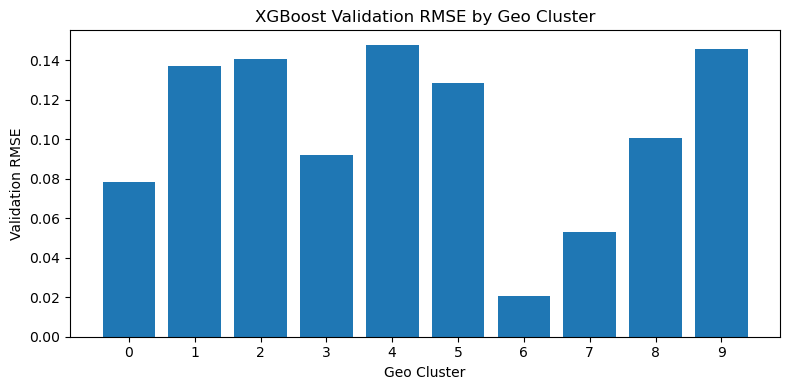

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# RMSE values for XGBoost per cluster
cluster_data = pd.DataFrame(
    {
        "Cluster": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        "RMSE_XGB": [
            0.0784,
            0.1370,
            0.1409,
            0.0920,
            0.1478,
            0.1287,
            0.0206,
            0.0529,
            0.1009,
            0.1455,
        ],
    }
)

plt.figure(figsize=(8, 4))
plt.bar(cluster_data["Cluster"], cluster_data["RMSE_XGB"])
plt.xlabel("Geo Cluster")
plt.ylabel("Validation RMSE")
plt.title("XGBoost Validation RMSE by Geo Cluster")
plt.xticks(cluster_data["Cluster"])
plt.tight_layout()
plt.show()

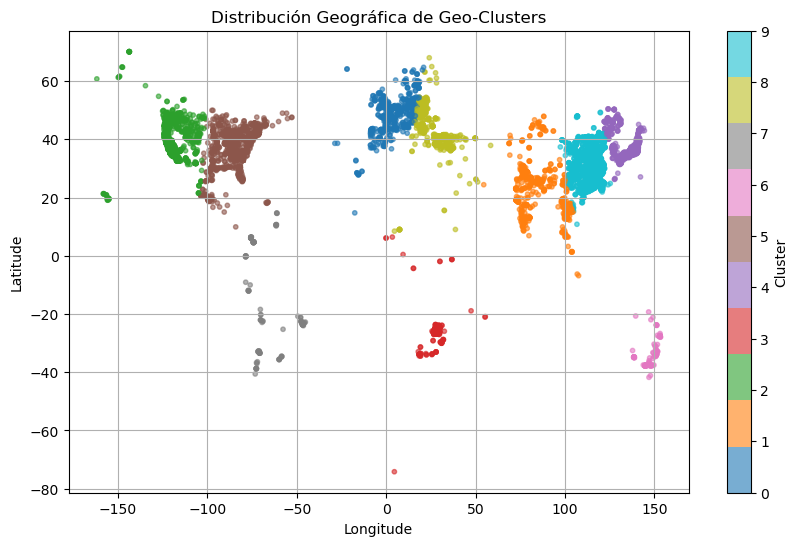

In [22]:
from sklearn.impute import SimpleImputer

train = pd.read_csv(
    "M:/DATA_ANALYTICS/Projects/Global_Air_Pollution_Prediction_Challenge/Data/train.csv"
)

# Crear features básicas
train["weekday_x_month"] = train["day_of_week"] * train["month"]

# Imputar NaNs en latitud/longitud
imputer = SimpleImputer(strategy="mean")
coords = imputer.fit_transform(train[["latitude", "longitude"]])

# Generar clusters
kmeans = KMeans(n_clusters=10, random_state=42)
train["geo_cluster"] = kmeans.fit_predict(coords)

# Plot de clusters geográficos
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    train["longitude"],
    train["latitude"],
    c=train["geo_cluster"],
    cmap="tab10",
    alpha=0.6,
    s=10,
)
plt.colorbar(scatter, ticks=range(10), label="Cluster")
plt.title("Distribución Geográfica de Geo-Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

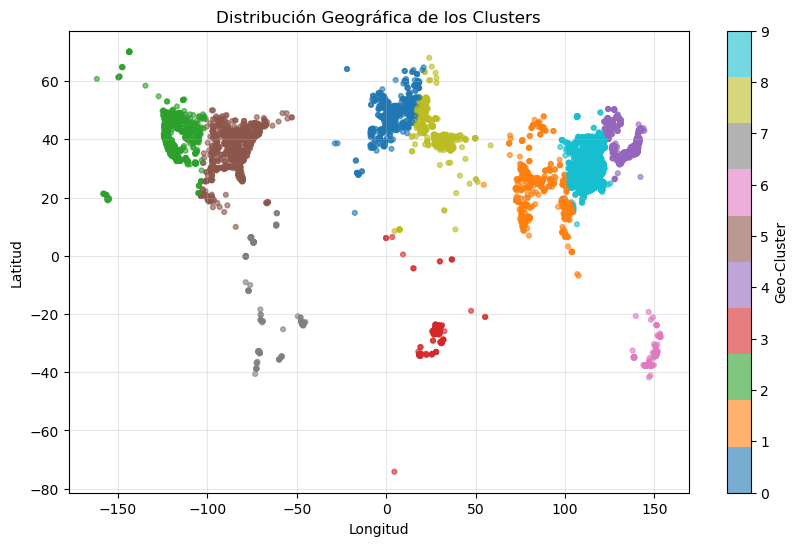

In [24]:
train = pd.read_csv(
    "M:/DATA_ANALYTICS/Projects/Global_Air_Pollution_Prediction_Challenge/Data/train.csv"
)

# 2. Crear la feature weekday_x_month (si no existe ya)
train["weekday_x_month"] = train["day_of_week"] * train["month"]

# 3. Imputar posibles NaNs en latitud y longitud
imputer = SimpleImputer(strategy="mean")
coords = imputer.fit_transform(train[["latitude", "longitude"]])

# 4. Aplicar KMeans para generar clusters geográficos
kmeans = KMeans(n_clusters=10, random_state=42)
train["geo_cluster"] = kmeans.fit_predict(coords)

# 5. Visualizar los clusters geográficos
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    train["longitude"],
    train["latitude"],
    c=train["geo_cluster"],
    cmap="tab10",
    alpha=0.6,
    s=12,
)
plt.colorbar(scatter, ticks=range(10), label="Geo-Cluster")
plt.title("Distribución Geográfica de los Clusters")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(alpha=0.3)
plt.show()

In [26]:
# 1. Añadir al DataFrame de train las predicciones revertidas del log
# (solo para validación interna)
train["pollution_pred"] = np.exp(
    train["pollution_value_log_pred"]
)  # asumiendo que la guardaste

# 2. Scatter actual vs predicho
plt.figure(figsize=(8, 8))
plt.scatter(
    train["pollution_value"],  # valor real
    train["pollution_pred"],  # valor predicho
    alpha=0.4,
    s=10,
)
max_val = max(train["pollution_value"].max(), train["pollution_pred"].max())
plt.plot([0, max_val], [0, max_val], "r--", lw=1)  # línea x=y
plt.xlabel("Pollution Value Real")
plt.ylabel("Pollution Value Predicho")
plt.title("Actual vs Predicho (Global)")
plt.grid(alpha=0.3)
plt.show()

# 3. Histograma de errores
errors = train["pollution_pred"] - train["pollution_value"]
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=50, alpha=0.7)
plt.axvline(0, color="k", linestyle="--")
plt.xlabel("Error (Predicho – Real)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores de Predicción")
plt.show()

KeyError: 'pollution_value_log_pred'